In [32]:
from htmd.ui import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator


Box is 60 * 66 * 98 A

flat bottom box (smooth surface, 40 × 40 × 60 Å3)

Original paper
kon = (1.6 ± 0.8) × 106 M−1 s−1 (95% confidence interval: 0.6−3.7 × 106 M−1 s−1

c = 20 mM

Panayotou et aL, 1993; Bu et aL, 1995; Ladbury et al., 1995; Morelock
et al., 1995; BorrelIo et al., 1996). Typicaily, dissociation constants (Kd)were found of
< 20 nM, association rate constants (ka)of 1.4 x 104 to 2.5 X 106 M-1s-l 
https://tspace.library.utoronto.ca/bitstream/1807/12312/1/NQ35322.pdf



In [33]:
nc_metric= MetricData()
nc_metric.load('metrics/nc.htmd')

rmsd_metric= MetricData()
rmsd_metric.load("metrics/rmsd.htmd")

conc = 0.02


In [34]:
def metricData2pandas(md):
    ll=[]
    for i in range(len(md.dat)):
        mval=md.dat[i]
        tname = md.trajectories[i].sim.trajectory[0]
        nf=md.trajectories[i].sim.numframes
        #ll.append({"Trajectory": tname, "Data": mval})
        tmp = pd.DataFrame(mval)
        tmp["Trajectory"]=tname
        tmp["TrajID"]=i
        tmp["Frame"]=tmp.reset_index().index
        ll.append(tmp)
    ld = pd.concat(ll)
    ld = ld.loc[ld.Frame<=800]
    return ld

In [35]:
def df2sens(df, thrs, column, less_is_bound=False):
    df=df.copy(deep=True)
    sens = []
    for thr in thrs:
        df["Bound"]=df[column]<=thr if less_is_bound else df[column]>=thr 
        tmp=df.groupby("Frame")["Bound"].mean()
        sens.append(pd.DataFrame({
            "Threshold": thr,
            "Time": tmp.index,
            "Bound": tmp.values,
            "Unbound": 1-tmp.values
        }))
    sens = pd.concat(sens)
    return sens


def plot_sens(nc_sens):
    nc_thrs = np.unique(nc_sens.Threshold)
    colors = pl.cm.jet(np.linspace(0,1,len(nc_thrs)))
    for i,thr in enumerate(nc_thrs):
        pl.plot(nc_sens.loc[nc_sens.Threshold==thr,"Unbound"], 
                color=colors[i], label=f"{thr:.02f}")
        pl.ylim(0,1.1)
    pl.legend(loc="lower left", ncol=3)
    pl.xlabel("Time (ns)")
    pl.ylabel("Unbound fraction")

In [152]:
def df2surv(df, thrs, column, less_is_bound=False):
    surv=[]
    df=df.copy(deep=True)
    for thr in thrs:
        df["Bound"]=df[column]<=thr if less_is_bound else df[column]>=thr 
        dft = df.groupby("Trajectory")
        # For each threshold
        for trn,trdf in dft:
            # Final time, censored
            tmp = (False, trdf["Frame"].max())
            # But if there is a bound frame, take it as an event
            mintbound = trdf.loc[trdf["Bound"],"Frame"].min()
            if not np.isnan(mintbound):
                tmp = (True, mintbound)
            surv.append({"Threshold": thr,
                         "Status": tmp[0],
                         "Time": tmp[1]})
    surv = pd.DataFrame(surv)
    return surv
        
def ulmCI(k):
    import scipy
    r= np.array([scipy.stats.chi2.ppf(.025,2*k)/2, 
                     scipy.stats.chi2.ppf(.975,2*(k+1))/2])
    if k==0:
        # overwrite NAN
        r[0]=0
    return r


def plot_surv(rmsd_surv_all):
    i = 0
    nc_thrs = np.unique(rmsd_surv_all.Threshold)
    colors = pl.cm.jet(np.linspace(0,1,len(nc_thrs)))
    for thr, rmsd_surv in rmsd_surv_all.groupby("Threshold"):
        time, survival_prob, conf_int = kaplan_meier_estimator(
            rmsd_surv["Status"], rmsd_surv["Time"], conf_type="log-log"
        )
        plt.step(time, survival_prob, where="post",
                color=colors[i], label=f"{thr:.2f}")
        plt.fill_between(time, conf_int[0], conf_int[1],
                        color=colors[i],
                        alpha=0.25, step="post")
        i=i+1
    plt.ylim(0, 1)
    plt.ylabel("Est. probability of survival $\hat{S}(t)$")
    plt.xlabel("Time before first binding (ns)")
    plt.legend(loc="lower left", ncol=3)

def surv2rates(rmsd_surv_all):
    unit = 1e6
    rmsd_rates = []
    for thr, rmsd_surv in rmsd_surv_all.groupby("Threshold"):
        nev = rmsd_surv["Status"].sum() 
        totT = rmsd_surv["Time"].sum()/1e9 # ns to seconds 
        ulm = ulmCI(nev)
        rmsd_rates.append({"Threshold": thr, 
                        "nev": nev,
                        "totT": totT,
                        "kon": nev/totT/conc/unit,
                        "klow": ulm[0]/totT/conc/unit,
                        "khigh": ulm[1]/totT/conc/unit})
    rmsd_rates=pd.DataFrame(rmsd_rates)
    rmsd_rates["Dklow"]=rmsd_rates.kon-rmsd_rates.klow
    rmsd_rates["Dkhigh"]=rmsd_rates.khigh-rmsd_rates.kon
    return rmsd_rates
 
def expfun1(t, tau):
    return np.exp(-t/tau)

def expfun2(t, A, tau1, tau2):
    return A*np.exp(-t/tau1)+(1-A)*np.exp(-t/tau2)

def expfunC(t, A, tau1):
    return A+(1-A)*np.exp(-t/tau1)

def expfun2C(t, A, B, tau1, tau2):
    return A*np.exp(-t/tau1)+B*np.exp(-t/tau2)+(1-A-B)




In [60]:
expfun1(0,1)

1.0

In [37]:
rmsd_df=metricData2pandas(rmsd_metric)
rmsd_df

,0,Trajectory,TrajID,Frame
0,52.621304,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,0
1,52.279541,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,1
2,55.513489,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,2
3,53.579525,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,3
4,44.058643,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,4
...,...,...,...,...
789,7.665262,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,789
790,8.433656,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,790
791,7.681581,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,791
792,7.552290,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,792


# Native contacts
## Sensitivity analysis

In [38]:
nc_df=metricData2pandas(nc_metric)
nc_df["NCF"]=nc_df[0]/328
nc_df

,0,Trajectory,TrajID,Frame,NCF
0,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,0,0.000000
1,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,1,0.000000
2,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,2,0.000000
3,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,3,0.000000
4,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,4,0.000000
...,...,...,...,...,...
789,12.776513,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,789,0.038953
790,12.624059,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,790,0.038488
791,13.762786,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,791,0.041960
792,23.518974,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,792,0.071704


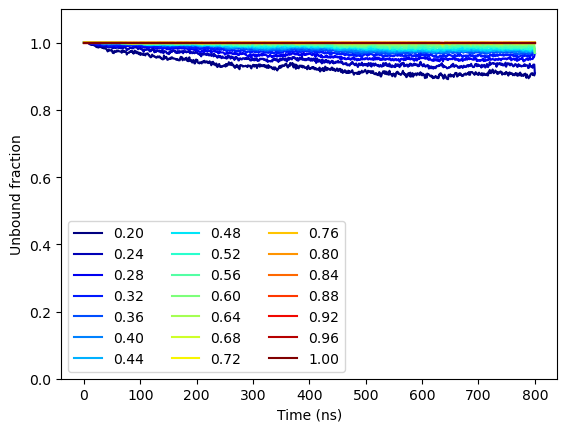

In [39]:
nc_thrs = np.linspace(0.2,1,41)
#nc_thrs = [.05, .1, .2, .3, .4]

nc_sens = df2sens(nc_df, nc_thrs, "NCF")
plot_sens(nc_sens)


## Survival curves

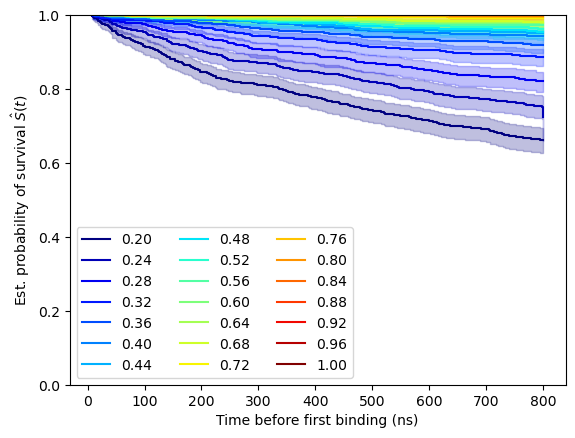

In [40]:
nc_surv_all = df2surv(nc_df, nc_thrs, "NCF")
plot_surv(nc_surv_all)

In [41]:
ulmCI(0)

array([0.        , 3.68887945])

<ErrorbarContainer object of 3 artists>

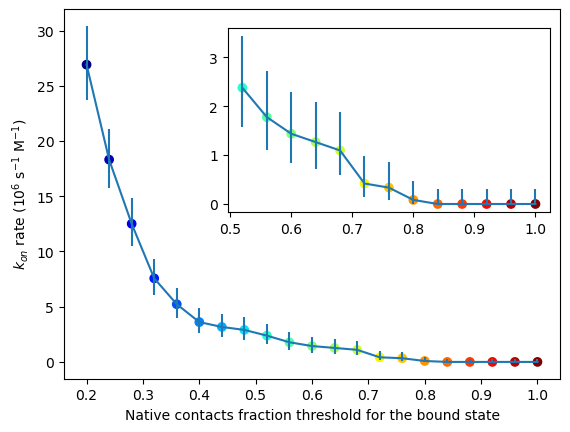

In [137]:
nc_rates = surv2rates(nc_surv_all)
rates = nc_rates

colors = pl.cm.jet(np.linspace(0,1,len(rates)))
ax=plt.subplot(1,1,1)
ax.scatter(rates.Threshold, rates.kon, color=colors)
rerr = rates.iloc[:,6:8].to_numpy().T
ax.errorbar(rates.Threshold, rates.kon, yerr=rerr)
ax.set_xlabel("Native contacts fraction threshold for the bound state")
ax.set_ylabel("$k_{on}$ rate ($10^6$ s$^{-1}$ M$^{-1}$)")

ax2 = ax.inset_axes([.33, .45, .65, .5 ])
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
_ = rates.Threshold >= 0.5
rates_ss = rates.loc[_]
ax2.scatter(rates_ss.Threshold, rates_ss.kon, color=colors[_])
ax2.errorbar(rates_ss.Threshold, rates_ss.kon, yerr=rerr[:,_])


In [119]:
.1/conc

5.0

# RMSD

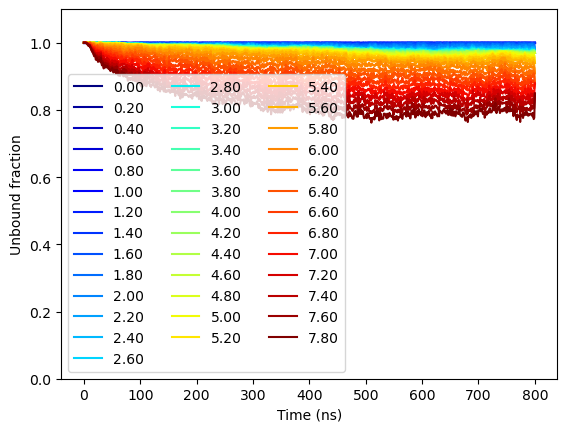

In [102]:
rmsd_thrs = np.arange(0,8,.2)
rmsd_sens = df2sens(rmsd_df, rmsd_thrs, 0, less_is_bound=True)

plot_sens(rmsd_sens)


In [158]:
import scipy
rmsd_sens_fits=[]
for thr, sens in rmsd_sens.groupby("Threshold"):
    if thr<=1:
        continue
    t1, _ = scipy.optimize.curve_fit(expfun1, sens.Time, sens.Unbound)
    try:
        t2, _ = scipy.optimize.curve_fit(expfun2, sens.Time, sens.Unbound)
    except:
        t2 = (0., 0., 0.)
    t3, _ = scipy.optimize.curve_fit(expfunC, sens.Time, sens.Unbound)
    try:
        t4, _ = scipy.optimize.curve_fit(expfun2C, sens.Time, sens.Unbound, bounds=(0,np.inf))
    except:
        t4 = (0., 0., 0., 0.)
    rmsd_sens_fits.append({
        "Threshold": thr,
        "tau1": t1[0],
        
        "tau21": t2[1],
        "tau22": t2[2],
        "A2": t2[0],

        "tau3": t3[1],
        "A3": t3[0],

        "A4": t4[0],
        "B4": t4[1],
        "tau41": t4[2],
        "tau42": t4[3],
    })
rmsd_sens_fits=pd.DataFrame(rmsd_sens_fits)
rmsd_sens_fits

/Users/toni/Apps/anaconda-m1/envs/htmd/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Threshold,tau1,tau21,tau22,A2,tau3,A3,A4,B4,tau41,tau42
0,1.2,5.215358e+06,8.194091e+06,18.682889,0.999920,23.182570,0.999869,1.308472e-04,6.769358e-08,23.452505,6.709683e+07
1,1.4,7.642043e+05,1.193954e+06,30.733796,0.999663,63.501204,0.999282,7.175607e-04,1.021684e-03,65.496281,2.011036e+05
2,1.6,2.211134e+05,2.419265e+10,339.045808,0.996804,339.043616,0.996804,3.195795e-03,1.512307e-12,339.048538,1.866034e+05
3,1.8,1.015612e+05,5.375724e+09,638.173306,0.990403,638.161726,0.990402,9.597710e-03,1.004320e-15,638.183451,5.799744e+04
4,2.0,6.190885e+04,5.681126e+09,918.195844,0.979971,918.176371,0.979971,1.011243e-02,9.917136e-03,918.119086,9.182841e+02
5,2.2,4.453314e+04,1.088510e+10,1340.648789,0.962980,1340.714405,0.962978,3.070739e-02,2.541361e-06,1054.283228,7.691461e+02
6,2.4,3.634990e+04,2.416548e+09,1629.881095,0.946917,1629.921753,0.946916,1.443234e-08,5.308926e-02,0.000832,1.630306e+03
7,2.6,3.245214e+04,3.407654e+09,1796.399763,0.935562,1796.426036,0.935561,6.443933e-02,1.244589e-09,1796.426871,1.651961e+03
8,2.8,3.017283e+04,3.080161e+09,1754.714320,0.932100,1754.726493,0.932100,7.846968e-09,6.790021e-02,1482.703280,1.754722e+03
9,3.0,2.880743e+04,9.931714e+08,1586.401509,0.934647,1586.452045,0.934644,6.535488e-02,2.756979e-07,1586.429991,1.734366e+03


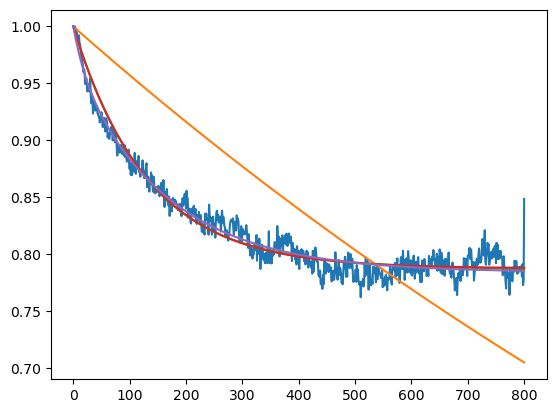

In [161]:
plt.plot(sens.Time, sens.Unbound)
plt.plot(sens.Time, expfun1(sens.Time, t1[0]))
plt.plot(sens.Time, expfun2(sens.Time, t2[0], t2[1], t2[2]))
plt.plot(sens.Time, expfunC(sens.Time, t3[0], t3[1]))
plt.plot(sens.Time, expfun2C(sens.Time, t4[0],t4[1],t4[2],t4[3] ))


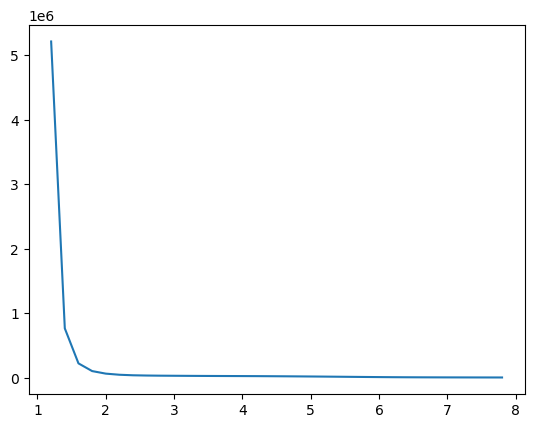

In [105]:
plt.plot(rmsd_sens_fits.Threshold, rmsd_sens_fits.tau1)

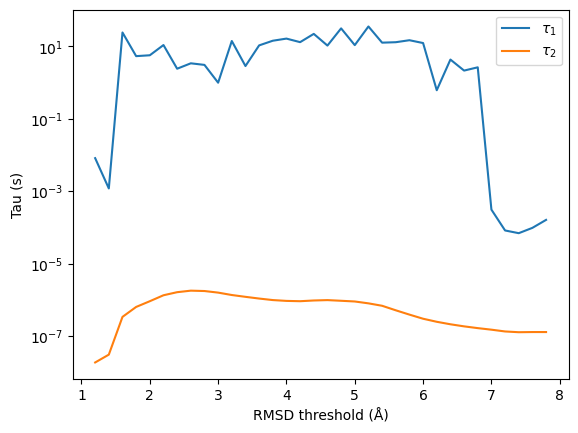

In [118]:
plt.plot(rmsd_sens_fits.Threshold, rmsd_sens_fits.tau21/1e9, label="$\\tau_1$")
plt.plot(rmsd_sens_fits.Threshold, rmsd_sens_fits.tau22/1e9, label="$\\tau_2$")
plt.yscale("log")
plt.xlabel("RMSD threshold (Å)")
plt.ylabel("Tau (s)")
plt.legend()

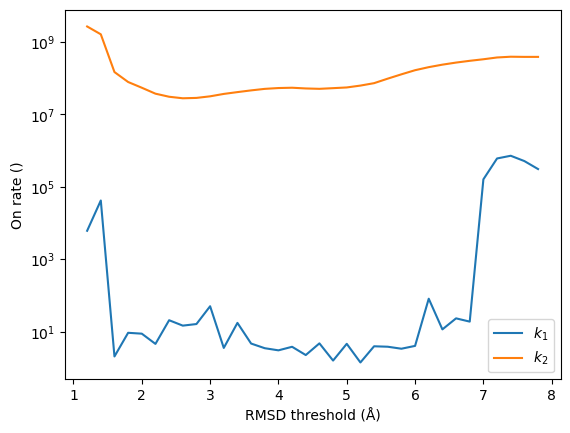

In [115]:
plt.plot(rmsd_sens_fits.Threshold, 1e9/rmsd_sens_fits.tau21/conc, label="$k_1$")
plt.plot(rmsd_sens_fits.Threshold, 1e9/rmsd_sens_fits.tau22/conc, label="$k_2$")
plt.yscale("log")
plt.xlabel("RMSD threshold (Å)")
plt.ylabel("On rate ()")
plt.legend()

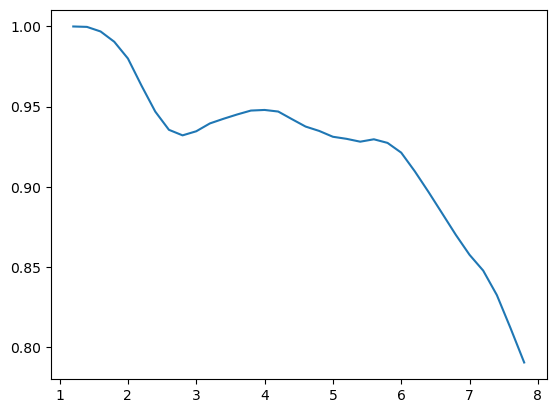

In [107]:
plt.plot(rmsd_sens_fits.Threshold, rmsd_sens_fits.A2, label="A")


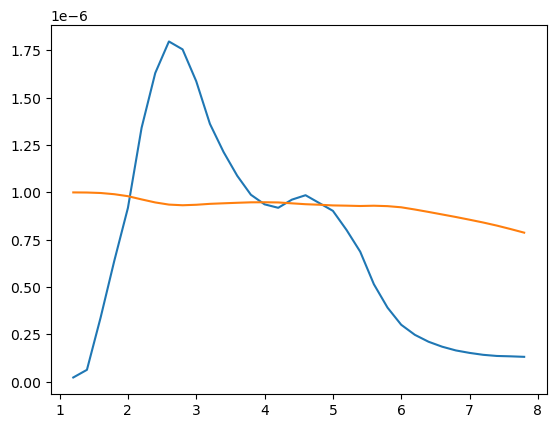

In [125]:
plt.plot(rmsd_sens_fits.Threshold, rmsd_sens_fits.tau3/1e9)


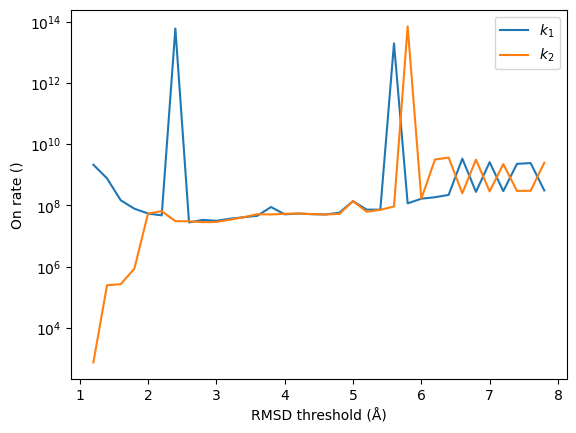

In [174]:
plt.plot(rmsd_sens_fits.Threshold, 1e9/rmsd_sens_fits.tau41/conc, label="$k_1$")
plt.plot(rmsd_sens_fits.Threshold, 1e9/rmsd_sens_fits.tau42/conc, label="$k_2$")
plt.yscale("log")
plt.xlabel("RMSD threshold (Å)")
plt.ylabel("On rate ()")
plt.legend()


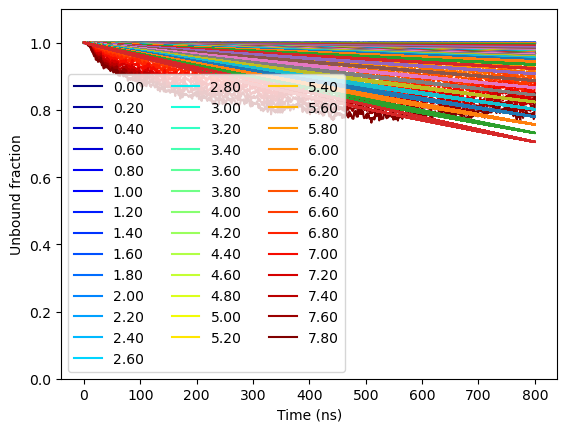

In [109]:
plot_sens(rmsd_sens)
for i, dt in rmsd_sens_fits.iterrows():
    plt.plot(rmsd_sens.Time, expfun1(rmsd_sens.Time, dt.tau1))

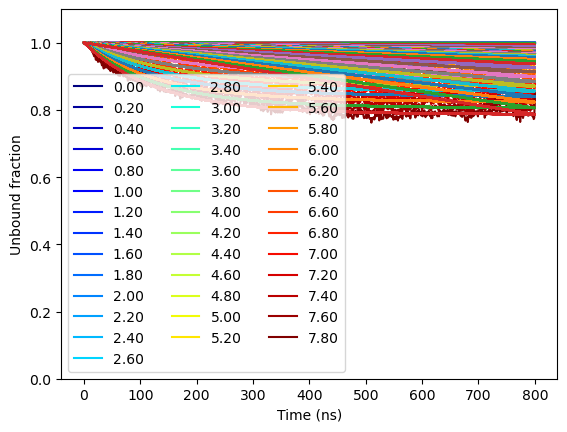

In [126]:
plot_sens(rmsd_sens)
for i, dt in rmsd_sens_fits.iterrows():
    plt.plot(rmsd_sens.Time, expfun2(rmsd_sens.Time, dt.A2, dt.tau21, dt.tau22))

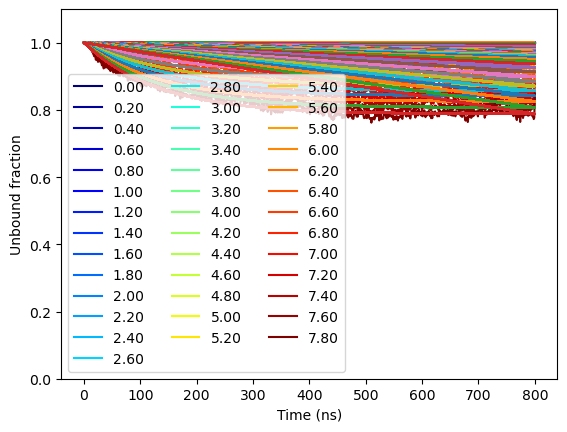

In [127]:
plot_sens(rmsd_sens)
for i, dt in rmsd_sens_fits.iterrows():
    plt.plot(rmsd_sens.Time, expfunC(rmsd_sens.Time, dt.A3, dt.tau3))

In [97]:
dt

Threshold    8.000000e+00
tau1         2.050122e+03
tau21        6.415144e+06
tau22        1.301391e+02
A2           7.672558e-01
Name: 13, dtype: float64

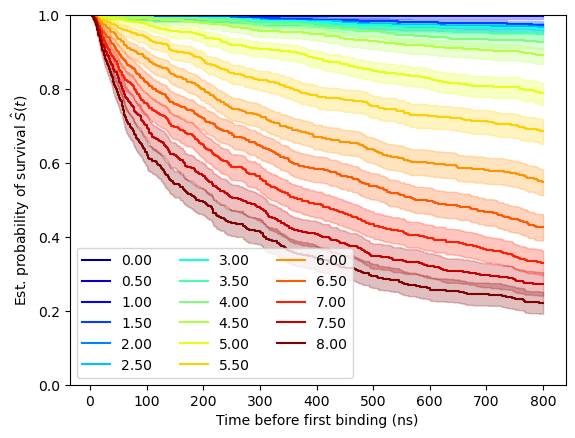

In [45]:
rmsd_surv_all = df2surv(rmsd_df, rmsd_thrs, 0, less_is_bound=True)
plot_surv(rmsd_surv_all)


In [46]:
len(rmsd_rates)

NameError: name 'rmsd_rates' is not defined

<ErrorbarContainer object of 3 artists>

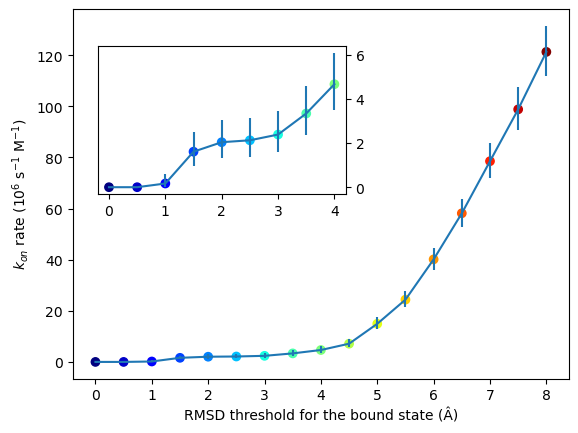

In [ ]:
rmsd_rates = surv2rates(rmsd_surv_all)
colors = pl.cm.jet(np.linspace(0,1,len(rmsd_rates)))

ax=plt.subplot(1,1,1)
ax.scatter(rmsd_rates.Threshold, rmsd_rates.kon, color=colors)
rerr = rmsd_rates.iloc[:,6:8].to_numpy().T
ax.errorbar(rmsd_rates.Threshold, rmsd_rates.kon, yerr=rerr)
ax.set_xlabel("RMSD threshold for the bound state (Â)")
ax.set_ylabel("$k_{on}$ rate ($10^6$ s$^{-1}$ M$^{-1}$)")
ax2 = ax.inset_axes([.05, .5, .5, .4 ])
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.scatter(rmsd_rates.Threshold[0:9], rmsd_rates.kon[0:9], color=colors[0:9])
ax2.errorbar(rmsd_rates.Threshold[0:9], 
             rmsd_rates.kon[0:9], yerr=rerr[:,0:9])
# plt.ylim(0,1e-3)

In [ ]:
19/0.000591/conc

1607445.0084602367

In [120]:
1/.05

20.0

In [176]:
%connect_info


{"key":"7dead7c5-c634-4a0c-8348-dfc82e6e4029","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9008,"control_port":9009,"shell_port":9010,"stdin_port":9011,"iopub_port":9012,"kernel_name":"pythonjvsc74a57bd01452c5f9af569f14e251f37270b0468f737eb4feb4ae3dd30961611d8e397e45"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-2998748OR6PtZ5Lpu.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
